In [19]:
# Importing important libraries

import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from selenium import webdriver # Selenium library for web automation
from selenium.webdriver.common.by import By # Locating elements on the page ("Load More") button
from selenium.webdriver.common.keys import Keys # Simulating keyboard input
from selenium.webdriver.common.action_chains import ActionChains # Performing mouse actions
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC 
import time
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import stopwords

In [4]:
# Defining our lists

reviews = []
ratings = []

In [5]:
# Initializing selenium driver
driver = webdriver.Firefox()


IMDB_url = 'https://www.imdb.com/title/tt1517268/reviews?ref_=tt_urv'

# Loading the IMDB reviews page using the selenium driver
driver.get(IMDB_url)

# Function to scroll down the page and click the "Load More" button
def scroll_and_click_load_more():
    try:
        load_more_button = driver.find_element(By.XPATH, '//button[text()="Load More"]')
        # Scrolling to the button
        driver.execute_script("arguments[0].scrollIntoView();", load_more_button)
        time.sleep(3)  # Waiting before clicking on the button
        load_more_button.click()
        return True
    except Exception as e:
        return False
    
while scroll_and_click_load_more():
    time.sleep(6)    

# Extracting the reviews and ratings from the loaded page
IMDB_soup = BeautifulSoup(driver.page_source, 'html.parser')
review_elements = IMDB_soup.find_all('div', class_='text show-more__control')
rating_elements = IMDB_soup.find_all('span', class_='rating-other-user-rating')

for user_review, user_rating in zip(review_elements, rating_elements):
    reviews.append(user_review.get_text(strip=True))
        # Checking if the rating element exists
    if user_rating is not None:
        ratings.append(user_rating.get_text(strip=True))
    else:
        ratings.append('N/A')  # Using 'N/A' for reviews without ratings

# Closing the browser
driver.quit()

In [6]:
#Validating the scraped data to make sure we got the right amount of reviews

print(len(reviews))
print(len(ratings))

920
920


In [7]:
# Storing the data in a data frame

reviews_dic = {'user reviews' : reviews, 'user ratings' : ratings}
IMDB_reviews_DF = pd.DataFrame(reviews_dic)
IMDB_reviews_DF.head()

,user reviews,user ratings
0,"Margot does the best with what she's given, bu...",6/10
1,The first reason to go see it:It's good fun. I...,7/10
2,"As a woman that grew up with Barbie, I was ver...",6/10
3,They really did some fantastic marketing with ...,10/10
4,I don't know if I put spoilers in here. I am s...,6/10


In [8]:
# Data cleaning

IMDB_reviews_DF.drop_duplicates(subset = ['user reviews'], inplace = True)
IMDB_reviews_DF.dropna(subset = ['user reviews'], inplace = True)

print(len(IMDB_reviews_DF))

920


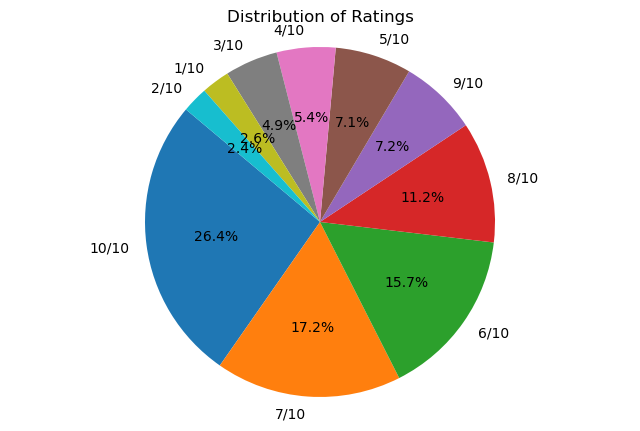

In [9]:
# Data visualization (Distribution of ratings)

rating_counts = IMDB_reviews_DF['user ratings'].value_counts()
plt.figure(figsize = (8, 5))
plt.pie(rating_counts, labels = rating_counts.index, autopct = '%1.1f%%', startangle = 140)
plt.axis('equal')
plt.title('Distribution of Ratings')
plt.show()

In [10]:
# Sentiment analysis on user reviews

def sentiment_analysis(review):
    analysis = TextBlob(review)
    if analysis.sentiment.polarity > 0.1:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Applying the function and storing it in a new column
IMDB_reviews_DF['sentiment'] = IMDB_reviews_DF['user reviews'].apply(sentiment_analysis)

# Counting the number of reviews in each sentiment category
sentiment_count = IMDB_reviews_DF['sentiment'].value_counts()
print(sentiment_count)
IMDB_reviews_DF.tail()

Positive    725
Neutral     175
Negative     20
Name: sentiment, dtype: int64


,user reviews,user ratings,sentiment
915,Margot Robbie was born to play Barbie. Of cour...,10/10,Positive
916,So many people have watched this movie and hav...,10/10,Positive
917,This movie was not made for younger kids who w...,1/10,Positive
918,I went to go see it in the theaters and I wish...,10/10,Positive
919,"It's a fine, fun movie but will never be a cla...",2/10,Positive


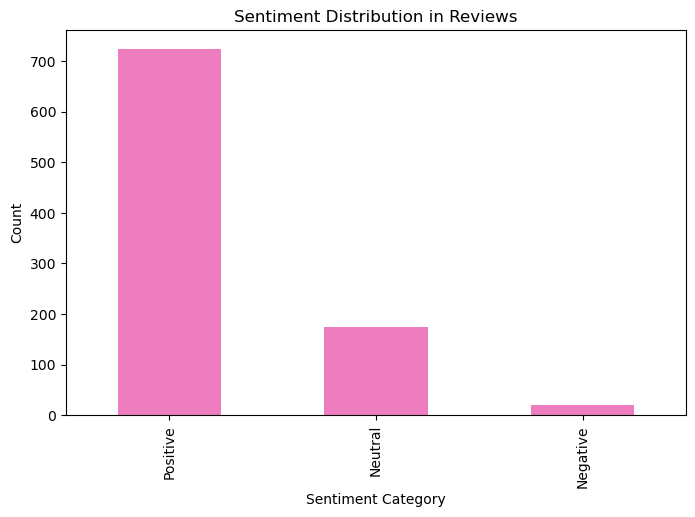

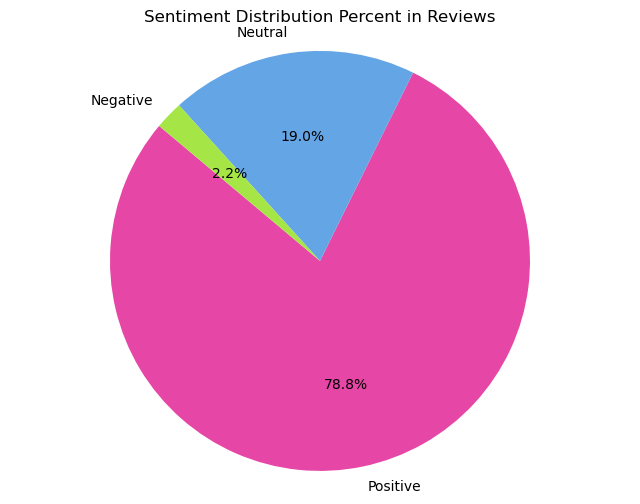

In [11]:
# Visualizing the sentiment distribution

lime_green = (165/255, 230/255, 70/255)
barbie_pink_color = (230/255, 70/255, 165/255)
light_blue = (100/255, 165/255, 230/255)

plt.figure(figsize = (8, 5))
sentiment_count.plot(kind = 'bar', color = barbie_pink_color, alpha = 0.7)
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Reviews')
plt.show()

colors = [barbie_pink_color, light_blue, lime_green]
plt.figure(figsize = (8, 6))
plt.pie(sentiment_count, labels = sentiment_count.index,colors = colors, autopct = '%1.1f%%', startangle = 140)
plt.axis('equal')
plt.title('Sentiment Distribution Percent in Reviews')
plt.show()


In [12]:
# Creating a CSV file from the data frame

csv_file = 'barbie_reviews_data.csv'
IMDB_reviews_DF.to_csv(csv_file, index= False)
print('Data saved to {}'.format(csv_file))

Data saved to barbie_reviews_data.csv


In [20]:
# Creating a CSV file with the word frequency count in user reviews to create a word cloud visualization in Tableau

# Reading the user reviews data
df = pd.read_csv('barbie_reviews_data.csv')

# Filtering full stop words (I, the, that...)
stop_words = set(stopwords.words("english"))

# Tokenization and counting words
word_counts = Counter()
for review in df['user reviews']:
    words = word_tokenize(review)
    words = [word for word in words if word.lower() not in stop_words]
    word_counts.update(words)

# Creating a new dataset with word frequencies
word_df = pd.DataFrame({'Word': word_counts.keys(), 'Frequency': word_counts.values()})

# Saving the CSV file
word_df.to_csv('word_frequencies.csv', index=False)